In [1]:
import tensorflow.keras as keras
import pickle
from pathlib import Path
from src.utils.preprocessing import preprocess_text
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

# Data Wrangling & Preprocessing
src/utils/make_datasets.py has been used to wrangle and preprocess the data.

It reads in raw text files, then applies 4 preprocessing steps to the data:
1. All text to lowercase
2. Remove html tags (<br/\> etc.)
3. Expand contractions (isn't > is not etc.)
4. Remove punctuation

This data is stored in a pandas dataframe. X is the review text, and y is the sentiment, where 1 = positive and 0 = negative. The data has been serialized to a pickle file.

# Exploratory Data Analysis

Load or make the data pickle:

In [2]:
path = Path('./data/imdb.pickle').resolve()

if not path.exists():
    print("Creating & pickling data")
    from src.utils.make_datasets import make_data_pickle
    make_data_pickle(toy_dataset=True)
    
else:
    print("Data pickle found")
    with path.open('rb') as f:
        data = pickle.load(f)
data.head()

Data pickle found


,doc,sentiment
0,several young iranian women dress as boys and ...,1
1,and all through the house is a special crypt e...,1
2,gespenster 2005 forms together with yella 2007...,1
3,culled from the real life exploits of chuck co...,1
4,the haunted world of edward d wood jr is not a...,1


Check for duplicates (duplicated values may result in training data leaking into test set):

In [3]:
data[data.duplicated(subset='doc', keep=False)]

,doc,sentiment
209,as a low budget enterprise in which the filmma...,1
269,this movie surprised me some things were clich...,1
305,red skelton was still another major star who m...,1
434,i really enjoyed this movie the script is fres...,1
507,bette midler is indescribable in this concert ...,1
532,bette midler showcases her talents and beauty ...,1
644,if you want scream or anything like the big st...,1
752,red skelton was still another major star who m...,1
952,this is the only full length feature film abou...,1
1160,love it love it love it this is another absolu...,1


In [4]:
data = data.drop_duplicates('doc')

Check for any missing data:

In [5]:
data['doc'].isnull().any()

False

Now let's have a look at some information about the dataset:

In [6]:
print("Dataset y distribution")
print(data.sentiment.value_counts())



Dataset y distribution
1    12465
0    12424
Name: sentiment, dtype: int64


We can see the data is evenly distibuted -  there is no skew or bias with respect to y value.

Let's look at a review:

In [7]:
print(data.doc[0])

several young iranian women dress as boys and try to get into a world cup qualifying match between iran and bahrain when they are caught they are penned in an area where the match remains within earshot but out of sight the prisoners plead to be let go but rules are rules what makes offside most affecting is that the young women are not portrayed as activists attacking the system they are simply soccer fans and patriots and despite the fact that they are clearly being treated unfairly they never lose their focus on the match and the historic victory that is within their nations grasp


139


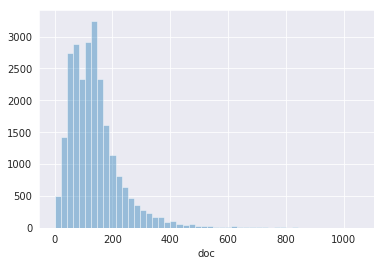

In [8]:
lengths = data.doc.apply(lambda x: len(x.split()))
sns.distplot(lengths, kde=False)
mean_length = np.mean(lengths)
print("{:.0f}".format(mean_length))

The majority of reviews appear to be around 250 words or less. 

Top 20 unigrams
vocabulary size: 62457


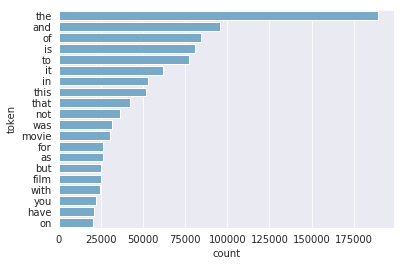

In [9]:
def word_distribution(text, ngram_range=(1,1)):
    cv = CountVectorizer(ngram_range=ngram_range)
    count_matrix = cv.fit_transform(text)
    token_sums = np.sum(count_matrix, axis = 0).A1
    vocab = cv.get_feature_names()
    print("vocabulary size: {}".format(len(vocab)))
    dist = zip(vocab, token_sums.tolist())
    dist = sorted(dist, key=lambda x: x[1], reverse=True)[0:20]
    x,y = zip(*dist)
    data = pd.DataFrame({'token':x,'count':y})
    sns.barplot(x='count',y='token', data= data, palette=sns.color_palette('Blues', n_colors=1))
    

print("Top 20 unigrams")
unigrams = word_distribution(data.doc)


Top 20 bigrams
vocabulary size: 928479


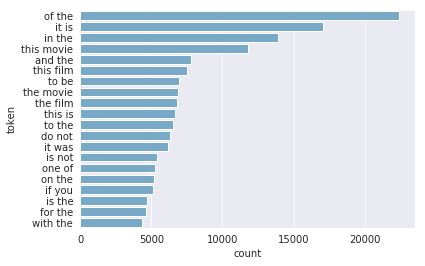

In [10]:
print("Top 20 bigrams")
bigrams = word_distribution(data.doc, ngram_range=(2,2))

Top 20 trigrams
vocabulary size: 2178660


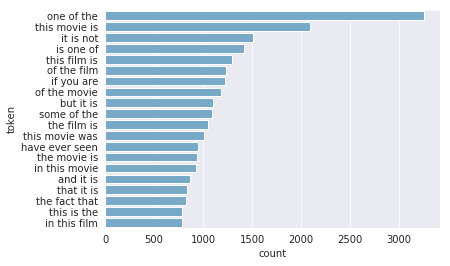

In [11]:
print("Top 20 trigrams")
trigrams = word_distribution(data.doc, ngram_range=(3,3))

The task is sentiment analysis so we will need to perform sequence classification. This means we should use a recurrent neural network. However, traditional neural networks do not handle long range dependencies very well. Since the movie reviews are up to 700 words long and on average 139 words long we will need to use an LSTM. LSTM's have an internal "memory" so they can find long range dependencies in sequences. 

To put together an LSTM first we need some word embeddings to represent words. We will download and unzip embeddings, if they are not present. We will use embeddings of dimensionality 50 to keep the model simple and minimise memory usage.

In [13]:
import zipfile
from src.utils.download import download_if_missing
embedding_path = download_if_missing('https://nlp.stanford.edu/data/glove.6B.zip', 'data/glove.6B.zip')
if not Path('data/glove.6B.50d.txt').resolve().exists():
    print("unzipping file")
    zipfile.ZipFile(Path('data/glove.6B.zip').resolve()).extract('glove.6B.50d.txt', path=Path('data').resolve())
else:
    print("embeddings found")

destination: /home/dan/IMDB/data/glove.6B.zip
file found
embeddings found


The full code for compiling and training the model is found in src/models/LSTM.py. The model has 3 components: The embedding layer (dimensionality 50), the LSTM layer (dimensionality 100), and the output layer (Dimensionality 1). The loss function is binary cross entropy, and the optimizer is the adam optimizer with default hyperparameters. The data is split into 70% training data, 10% validation data and 20% validation data. To help prevent overfitting, early stopping is used to halt training of the model when validation loss starts to increase. Reviews are padded/truncated to 250 words, primarily for performance reasons.

In [14]:
from src.models import LSTM

history, y_test, y_pred = LSTM.train_model()


Loaded 400000 embeddings
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          2578400   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 2,638,901
Trainable params: 60,501
Non-trainable params: 2,578,400
_________________________________________________________________
None
Train on 15928 samples, validate on 3983 samples
Epoch 1/100
15928/15928 [==============================] - 78s 5ms/step - loss: 0.6033 - acc: 0.6715 - val_loss: 0.6028 - val_acc: 0.6869
Epoch 2/100
15928/15928 [==============================] - 77s 5ms/step - loss: 0.5396 - acc: 0.7310 - val_loss: 0.5228 - val_acc: 0.7391
Epoch 3/100
15928/15928 [===========

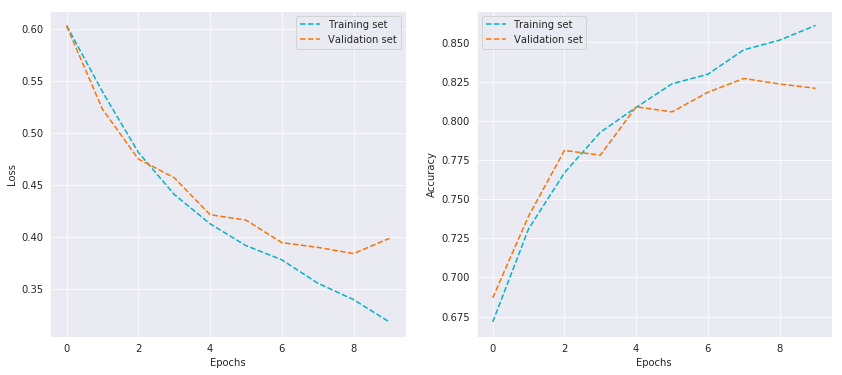

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].plot(history.history['loss'], label='Training set', color='xkcd:turquoise blue', ls='--' )
ax[0].plot(history.history['val_loss'], label='Validation set', color='xkcd:orange', ls='--')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.history['acc'], label='Training set', color='xkcd:turquoise blue', ls='--')
ax[1].plot(history.history['val_acc'], label='Validation set', color='xkcd:orange', ls='--')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

Above are learning curves for loss and accuracy. We can see that the model is still overfitting the training data slightly; with training, validation and testing accuracies of 0.84, 0.81 and 0.80 respectively. For an ideal model these would be equal.

Text(33,0.5,'Predicted Sentiment')

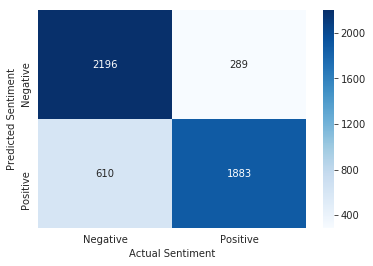

In [16]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, fmt='g',ax=ax, xticklabels=['Negative', 'Positive'], yticklabels=['Negative','Positive'])
ax.axes.set_xlabel('Actual Sentiment')
ax.axes.set_ylabel('Predicted Sentiment')

From the confusion matrix we can see that the model is better at classifying negative reviews than positive reviews. However overall we have acheived a pretty good model for classifying sentiment in movie reviews.

Future work:

    1. Investigate other embedding systems (word2vec, fastText)
    2. Cross validate hyper-parameters
    3. Use embeddings of greater dimensionality
    4. Use GPU accelleration
    5. Investigate other architectures